# Reading data

In [164]:
import mne
import numpy as np
import pandas as pd
import re

## Load data

In [150]:
def remove_unnecessary_events(raw, events, events_id, events_names = ['Time 0/', 'New Segment/']):
    events_to_remove = []
    for event_name in events_names:
        events_to_remove.append(events_id[event_name])
    
    # Filter out the unwanted events
    filtered_events = np.array([event.tolist() for event in events if event[2] not in events_to_remove])
    filtered_event_id = {key: value for key, value in events_id.items() if value not in events_to_remove}
    
    new_event_desc = {value:str(key) for key, value in filtered_event_id.items()}
    
    # Use mne.annotations_from_events to create new annotations
    new_annotations = mne.annotations_from_events(filtered_events, sfreq=raw.info['sfreq'], event_desc=new_event_desc)
    
    # Set new annotations to raw data
    raw_copy = raw.copy().set_annotations(new_annotations)

    return raw_copy

In [151]:
signal_frequency = 64

In [248]:
dir = '../data/sst_old'
filename = 'AD1406_SST14_Artif Rej 75'
# filename2 = 'AB2407_SST14_new_Artif Rej 75'
# dir = '../data/gng'
# filename = 'GNG_AA0303-64 el'

raw = mne.io.read_raw_brainvision(f'{dir}/{filename}.vhdr')
events, event_id = mne.events_from_annotations(raw)
raw = remove_unnecessary_events(raw, events, event_id)

events, event_id = mne.events_from_annotations(raw)

Extracting parameters from ../data/sst_old/AD1406_SST14_Artif Rej 75.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'Stimulus/ 3-B-NOSTOP-L', 'Stimulus/ 3-B-NOSTOP-R', 'Stimulus/ 3-B-STOP1-SE-L', 'Stimulus/ 3-B-STOP1-SS-R', 'Stimulus/ 3-B-STOP2-SE-R', 'Stimulus/ 3-B-STOP2-SS-L', 'Stimulus/ 3-B-STOP3-SE-L', 'Stimulus/ 3-B-STOP3-SS-L', 'Stimulus/ 3-B-STOP3-SS-R', 'Stimulus/ 3-B-STOP4-SE-R', 'Stimulus/ 3-B-STOP4-SS-R', 'Stimulus/ 3-B-STOP5-SE-L', 'Stimulus/ 3-B-STOP5-SS-R', 'Stimulus/ 3-R-B-NOSTOP-L', 'Stimulus/ 3-R-B-NOSTOP-R', 'Stimulus/ 3-R-B-STOP1-SE-L', 'Stimulus/ 3-R-B-STOP2-SE-R', 'Stimulus/ 3-R-B-STOP3-SE-L', 'Stimulus/ 3-R-B-STOP4-SE-R', 'Stimulus/ 3-R-B-STOP5-SE-L', 'Stimulus/ 3-STOP1-SE-L', 'Stimulus/ 3-STOP1-SS-R', 'Stimulus/ 3-STOP2-SE-R', 'Stimulus/ 3-STOP2-SS-L', 'Stimulus/ 3-STOP3-SE-L', 'Stimulus/ 3-STOP3-SS-L', 'Stimulus/ 3-STOP3-SS-R', 'Stimulus/ 3-STOP4-SE-R', 'Stimulus/ 3-STOP4-SS-R', 'Stimulus/ 3-STOP5-SE-L', 'Stimulus/ 3-ST

In [250]:
# Define the mapping function using regular expressions
def map_event(event):
    # Patterns for matching
    patterns = {
        r'^Stimulus/ 3-B-NOSTOP.*': 'go/nostop',
        r'^Stimulus/ 3-B-STOP(\d+).*': lambda m: f'go/stop/{m.group(1)}',
        r'^Stimulus/ 3-R-B-NOSTOP.*': 'response/correct',
        r'^Stimulus/ 3-R-B-STOP(\d+).*': lambda m: f'response/incorrect/{m.group(1)}',
        r'^Stimulus/ 3-STOP(\d+).*': lambda m: f'stop/{m.group(1)}'
    }	
    # Check each pattern
    for pattern, replacement in patterns.items():
        match = re.fullmatch(pattern, event)
        if match:
            return replacement if not callable(replacement) else replacement(match)
    # Default return value if no pattern matches
    return 'unknown'

# Define the function to categorize events into 'go', 'response', or 'stop'
def categorize_type(event_general):
    if 'go' in event_general:
        return 'go'
    elif 'response' in event_general:
        return 'response'
    elif 'stop' in event_general:
        return 'stop'
    return 'unknown'

# Define the SSD mapping
ssd_mapping = {
    1: 100,
    2: 150,
    3: 200,
    4: 250,
    5: 300,
    6: 350,
    7: 400
}

# Define the function to map to SSD values
def map_ssd(event_general):
    if 'response/incorrect/' in event_general:
        match = re.search(r'response/incorrect/(\d+)', event_general)
        if match:
            number = int(match.group(1))
            return ssd_mapping.get(number, np.nan)  # Use np.nan for missing values
    return np.nan

In [251]:
events_df = pd.DataFrame(events, columns=['latency', 'duration', 'id'])

# Invert the dictionary to map IDs to event names
id_to_event = {value: key for key, value in event_id.items()}

# Create a new 'event' column by mapping 'id' to event names
events_df['event'] = events_df['id'].map(id_to_event)
events_df['event_general'] = events_df['event'].apply(map_event)
events_df['type'] = events_df['event_general'].apply(categorize_type)
events_df['ssd'] = events_df['event_general'].apply(map_ssd)

# Calculate the mean of the 'ssd' column
ssd_mean = np.nanmean(events_df['ssd'])
# Create the 'ssd_centered' column by subtracting the mean from each 'ssd' value
events_df['ssd_centered'] = events_df['ssd'] - ssd_mean

In [252]:
events_df

,latency,duration,id,event,event_general,type,ssd,ssd_centered
0,13,0,10002,Stimulus/ 3-B-NOSTOP-R,go/nostop,go,NaN,NaN
1,35,0,10015,Stimulus/ 3-R-B-NOSTOP-R,response/correct,response,NaN,NaN
2,128,0,10001,Stimulus/ 3-B-NOSTOP-L,go/nostop,go,NaN,NaN
3,152,0,10014,Stimulus/ 3-R-B-NOSTOP-L,response/correct,response,NaN,NaN
4,243,0,10002,Stimulus/ 3-B-NOSTOP-R,go/nostop,go,NaN,NaN
...,...,...,...,...,...,...,...,...
139,7619,0,10029,Stimulus/ 3-STOP4-SS-R,stop/4,stop,NaN,NaN
140,7718,0,10002,Stimulus/ 3-B-NOSTOP-R,go/nostop,go,NaN,NaN
141,7738,0,10015,Stimulus/ 3-R-B-NOSTOP-R,response/correct,response,NaN,NaN
142,7833,0,10001,Stimulus/ 3-B-NOSTOP-L,go/nostop,go,NaN,NaN


In [253]:
events_df.to_csv(f'{filename}_events.csv')

In [254]:
events_df[events_df['event_general'].str.contains('response/incorrect/')]

,latency,duration,id,event,event_general,type,ssd,ssd_centered
12,607,0,10017,Stimulus/ 3-R-B-STOP2-SE-R,response/incorrect/2,response,150.0,-41.666667
39,2103,0,10018,Stimulus/ 3-R-B-STOP3-SE-L,response/incorrect/3,response,200.0,8.333333
46,2447,0,10017,Stimulus/ 3-R-B-STOP2-SE-R,response/incorrect/2,response,150.0,-41.666667
65,3491,0,10016,Stimulus/ 3-R-B-STOP1-SE-L,response/incorrect/1,response,100.0,-91.666667
94,5100,0,10019,Stimulus/ 3-R-B-STOP4-SE-R,response/incorrect/4,response,250.0,58.333333
135,7401,0,10020,Stimulus/ 3-R-B-STOP5-SE-L,response/incorrect/5,response,300.0,108.333333


---

In [44]:
f = f'{dir}/{filename}.dat'
f

'../data/gng/GNG_AA0303-64 el.dat'

In [45]:
# n_data_ch = 1
# with open(f, "rb") as fid:
#     fid.seek(7)
#     block = np.empty((n_data_ch, 20))
#     for ii in range(20):
#         line = fid.readline().decode("ASCII")
#         line = line.strip()
#         # Not sure why we special-handle the "," character here,
#         # but let's just keep this for historical and backward-
#         # compat reasons  
#         if " " in line:
#             line_data = line.split()
#             print(line_data)
#         elif "," in line:
#             # likely exported from BrainVision Analyzer?
#             line_data = line.split(",")
#             print(line_data)
#         elif n_data_ch == 1:
#             line_data = [line]
#         else:
#             raise RuntimeError(
#                 "Unknown BrainVision data format encountered. "
#                 "Please contact the MNE-Python developers."
#             )
#         block[:n_data_ch, ii] = [float(part) for part in line_data]

In [46]:
raw.info

Measurement date,"May 25, 2019 15:41:48 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


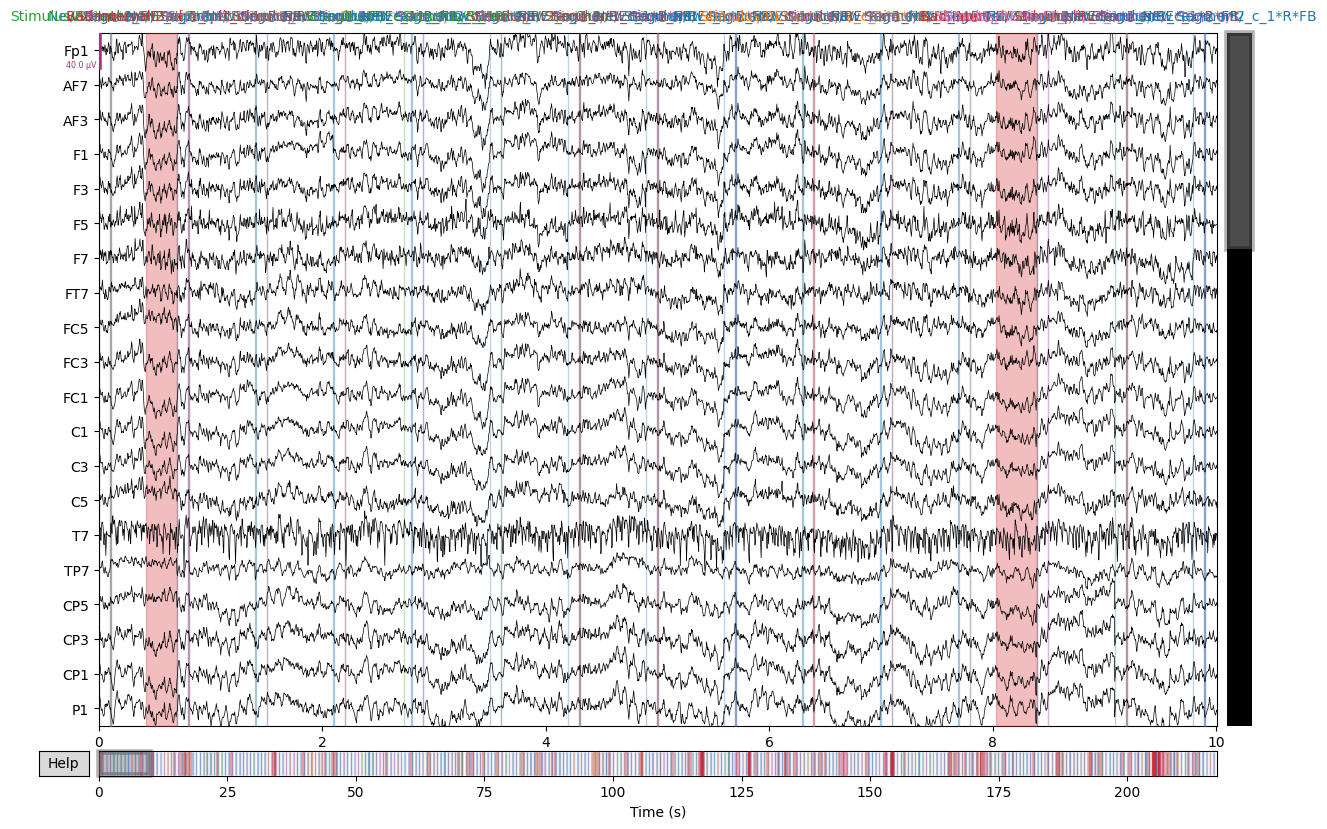

In [48]:
fig = raw.plot()

In [82]:
tmin, tmax = -0.2, 1.6

# Read epochs
epochs = mne.Epochs(
    raw=raw,
    events=events,
    event_id=ids,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    reject_by_annotation=True,
    preload=True,
    event_repeated='merge',
    on_missing = "warn",
)

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_19246/3110722822.py:4: RuntimeWarning: No matching events found for Stimulus/CU*ex*1_n*1_c_1*R*FB (event id 1)
  epochs = mne.Epochs(
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_19246/3110722822.py:4: RuntimeWarning: No matching events found for Stimulus/CU*ex*1_n*1_c_1*R*FG (event id 12)
  epochs = mne.Epochs(
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_19246/3110722822.py:4: RuntimeWarning: No matching events found for Stimulus/FB*ex*1_n*1_c_1*R (event id 2)
  epochs = mne.Epochs(
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_19246/3110722822.py:4: RuntimeWarning: No matching events found for Stimulus/FB*ex*2_n*2_c_1*R (event id 3)
  epochs = mne.Epochs(
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_19246/3110722822.py:4: RuntimeWarning: No matching events found for Stimulus/RE*ex*1_n*1_c_1*R*FB (event id 4)
  epochs = mne.Epochs(
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc

ValueError: max() arg is an empty sequence

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_19246/932165314.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = epochs.plot( n_epochs=3, events=True)


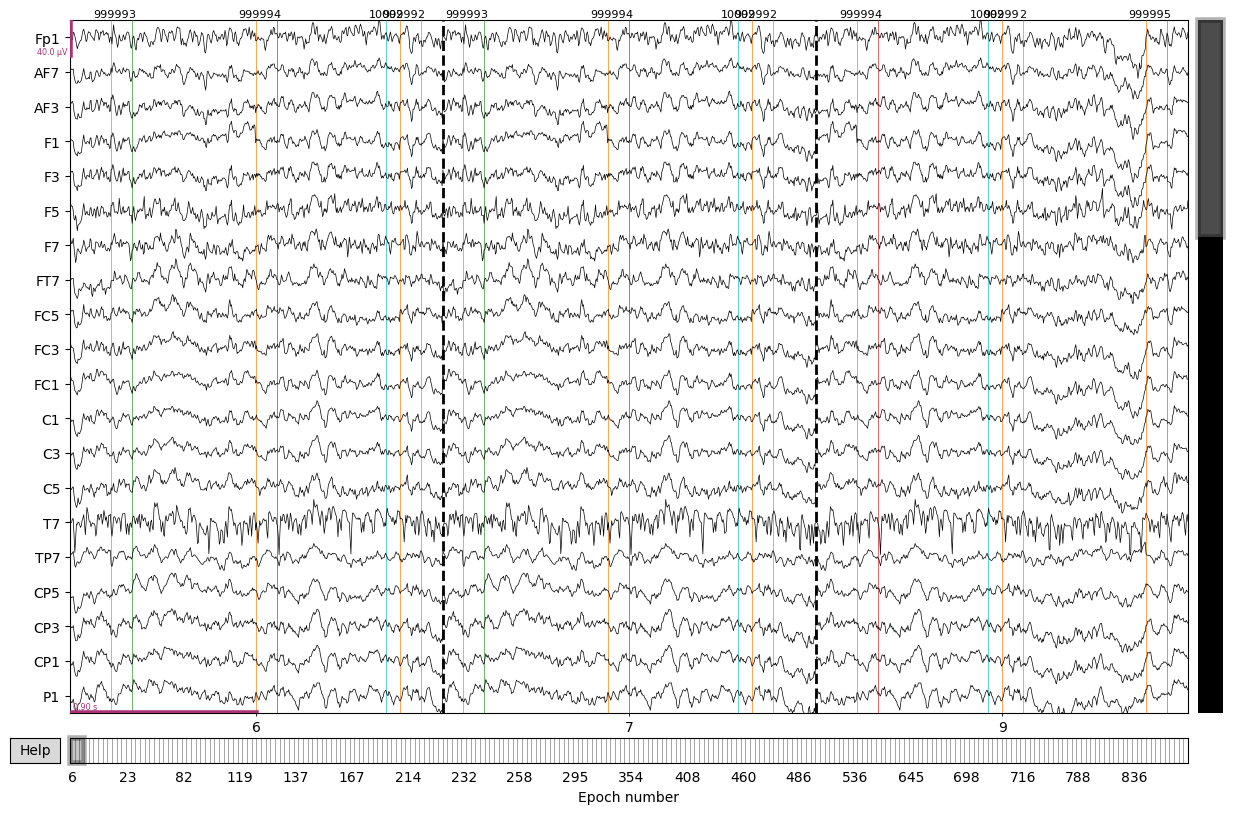

In [76]:
fig = epochs.plot( n_epochs=3, events=True)

In [72]:
events[:20,:]

array([[    0,     0, 99999],
       [   26,     0, 10011],
       [   26,     0, 10012],
       [  179,     0, 99999],
       [  205,     0, 10004],
       [  205,     0, 10012],
       [  358,     0, 99999],
       [  384,     0, 10012],
       [  384,     0, 10006],
       [  537,     0, 99999],
       [  563,     0, 10004],
       [  563,     0, 10012],
       [  699,     0, 10002],
       [  716,     0, 99999],
       [  742,     0, 10009],
       [  742,     0, 10012],
       [  895,     0, 99999],
       [  921,     0, 10012],
       [  921,     0, 10011],
       [ 1074,     0, 99999]])

In [61]:
epochs.metadata